In [1]:
import os, warnings, torch

import torch.nn as nn
import scanpy as sc
import pandas as pd

from model.nicheTrans_ct_attribution_STARmap_PLUS import *
from datasets.data_manager_STARmap_PLUS import AD_Mouse

from utils.utils import *
from utils.utils_dataloader import *
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
%run ./args/args_STARmap_PLUS.py
args = args

### Load dataset

In [3]:
# create the dataloaders
dataset = AD_Mouse(AD_adata_path=args.AD_adata_path, Wild_type_adata_path=args.Wild_type_adata_path, n_top_genes=args.n_top_genes)
_, testloader, valloader = ad_mouse_dataloader(args, dataset)

------Calculating spatial graph...
The graph contains 124464 edges, 10372 cells.
12.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 115608 edges, 9634 cells.
12.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 96408 edges, 8034 cells.
12.0000 neighbors per cell on average.
=> AD Mouse loaded
Dataset statistics:
  ------------------------------
  subset   | # num | 
  ------------------------------
  train    |  10372 spots, 894.0 positive tao, 291.0 positive plaque 
  test     |   9634 spots, 620.0 positive tao, 195.0 positive plaque 
  ------------------------------


### Load model

In [4]:
# create the model
source_dimension, target_dimension = dataset.rna_length, dataset.target_length
model = NicheTrans_ct(source_length=source_dimension, target_length=target_dimension, noise_rate=args.noise_rate, dropout_rate=args.dropout_rate)
model = nn.DataParallel(model).cuda()

model.load_state_dict(torch.load('NicheTrans_*_STARmap_PLUS.pth'))
model.eval() 

DataParallel(
  (module): NicheTrans_ct(
    (encoder_rna): NetBlock(
      (noise_dropout): Dropout(p=0.5, inplace=False)
      (linear_list): ModuleList(
        (0): Linear(in_features=1719, out_features=512, bias=True)
        (1): Linear(in_features=512, out_features=256, bias=True)
      )
      (bn_list): ModuleList(
        (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation_list): ModuleList(
        (0-1): 2 x LeakyReLU(negative_slope=0.01)
      )
      (dropout_list): ModuleList(
        (0): Dropout(p=0.25, inplace=False)
      )
    )
    (projection_rna): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): ReLU(inplace=True)
    )
    (fusion_omic): Self_Attention(
      (to_q): Sequential(
        (0): Linear(in_features

### Inference 

In [5]:
inputs_list = []

with torch.no_grad():
    for _, (rna, protein, cell, rna_neighbor, cell_neighbor, _) in enumerate(testloader):

        rna, protein, cell, rna_neighbor, cell_neighbor = rna.cuda(), protein.cuda(), cell.cuda(), rna_neighbor.cuda(), cell_neighbor.cuda()
        cell_inf = torch.cat([cell[:, None, :], cell_neighbor], dim=1)
        omics = torch.cat([rna[:, None, :], rna_neighbor], dim=1)

        temp_length = cell_inf.size(-1)

        temp_input = torch.cat([omics, cell_inf], dim=2)

        outputs = model(temp_input)
        outputs = torch.sigmoid(outputs)
        
        ###########
        # change this threshold to involve more samples
        mask = outputs[:, 0] >0.05

        inputs_list.append(temp_input[mask])

inputs_list = torch.cat(inputs_list, dim=0)

### Calculate and Visualize the gradients

In [16]:
# do the gradient calculation
from captum.attr import IntegratedGradients

ig = IntegratedGradients(model)

baseline = torch.zeros_like(inputs_list).cuda()

# Compute attributions
attributions = ig.attribute(inputs_list, baseline, target=0) 
attributions = attributions.detach().cpu().numpy()

attributions = np.abs(attributions)
grad_norm = attributions.sum(axis=0).sum(axis=0)[0: -13]

In [ ]:
num_genes = 30

top_indices = np.argsort(grad_norm)[-num_genes:]
temp_mask = grad_norm >= grad_norm[top_indices[0]]

highly_correlated_genes_0 = dataset.source_panel[top_indices]

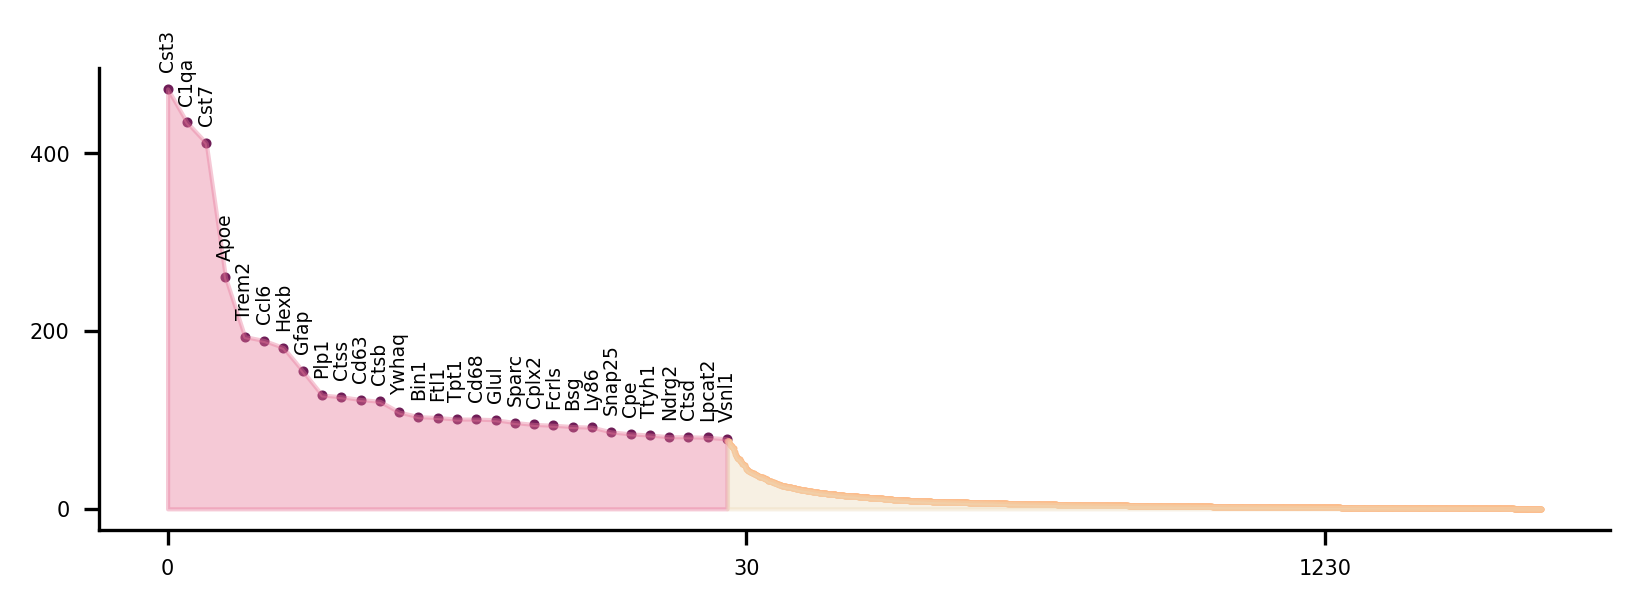

In [18]:
sorted_data = np.sort(grad_norm.squeeze())[::-1]
indices = np.arange(len(sorted_data))

fig, ax = plt.subplots(1, figsize=(6.5, 2), dpi=300)

plt.scatter(indices[0:30], sorted_data[0:30], s=2, color='#6F1D57')
plt.scatter(29 + (indices[30:] -29)/40, sorted_data[30:], s=0.2, color='#FCBD8B')

num_genes
for i in range(num_genes):
    plt.annotate(highly_correlated_genes_0[num_genes-i -1],
                 xy=(i, sorted_data[i]),
                 xytext=(0, 5),  
                 textcoords='offset points',
                 ha='center',  
                 rotation=90,
                 fontsize=4.5)  

                 
plt.fill_between(indices[0:30], sorted_data[0:30], color='#E8789A', alpha=0.4)
plt.fill_between(29 + (indices[30:]- 29 )/40, sorted_data[30:], color='#EDDAB9', alpha=0.4)

custom_xticks = [0, 30, 60]
custom_xticklabels = ['0', '30', '1230']

ax.set_xticks(custom_xticks)
ax.set_xticklabels(custom_xticklabels, fontsize=5)
plt.yticks(fontsize=5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()